In [1]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
!pip install shap

from torchvision import datasets, transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data

In [3]:
survey_df = pd.read_csv('/content/drive/My Drive/SharedResponsesSurvey.csv')
print(f"survey_df: {survey_df.shape}")

<ipython-input-3-254367ce059d>:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_df = pd.read_csv('/content/drive/My Drive/SharedResponsesSurvey.csv')


survey_df: (11286141, 27)


In [4]:
survey_df = survey_df.dropna()  # drop all rows with NaN values
survey_df = survey_df.replace('', np.nan).dropna()    # drop empty string rows
survey_df = survey_df.replace([np.inf, -np.inf], np.nan).dropna()   # drop inf/-inf rows
print(f"survey_df (dropped nan, empty string, inf/-inf): {survey_df.shape}")

survey_df (dropped nan, empty string, inf/-inf): (8833378, 27)


In [5]:
headers = survey_df.columns
print(f"Header names: {headers}")

# Randomly sample 10% examples from survey_df
sampled_df = survey_df.sample(frac=0.1, random_state=1)

print(f"sampled_df: {sampled_df.shape}")

# Once sampled_df is created, delete the original survey_df to free up System RAM
del survey_df
gc.collect()

Header names: Index(['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioOrder',
       'Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 'AttributeLevel',
       'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Review_age', 'Review_education',
       'Review_gender', 'Review_income', 'Review_political',
       'Review_religious'],
      dtype='object')
sampled_df: (883338, 27)


0

In [6]:
sampled_df.head()

,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,...,Template,DescriptionShown,LeftHand,UserCountry3,Review_age,Review_education,Review_gender,Review_income,Review_political,Review_religious
6480074,isR4EQ9Ash2bnBRK7,-1516820409_9509008369262790.0,9.509008e+15,5,1,1,0,0,Hoomans,Species,...,Desktop,0.0,0.0,BRA,25.0,bachelor,female,above100000,0.74,0.67
11059629,aguaGJMLnzFgJXyKf,1974129059_2718322910552958.0,2.718323e+15,9,1,1,0,0,Fit,Fitness,...,Mobile,0.0,1.0,USA,30.0,graduate,male,above100000,0.23,0.91
8202560,R9xbKa2FEhip6YSjm,-204794111_9494983543702578.0,9.494984e+15,1,1,0,1,0,Female,Gender,...,Mobile,0.0,0.0,FRA,15.0,high,female,default,0.50,0.00
3166049,ck58YEaeBQ9jCK4QQ,258005752_6142338223464052.0,6.142338e+15,9,0,0,0,2,Hoomans,Species,...,Desktop,0.0,0.0,MEX,32.0,bachelor,male,10000,0.77,0.11
4119534,4462sqdCasKoYPhFe,981475550_796567439985240.0,7.965674e+14,2,0,0,0,2,Female,Gender,...,Desktop,0.0,1.0,SWE,23.0,bachelor,male,80000,0.00,1.00


Data preprocessing

In [7]:
# Convert Reviewer income to income level and education to education level
income_mapping = {
    'under5000': 0,          # Represent under $5,000 with 0
    '5000': 0.5,            # Lower bound for $5,000-$10,000
    '10000': 1,          # Lower bound for $10,001-$15,000
    '15000': 1.5,          # Lower bound for $15,001-$25,000
    '25000': 2.5,          # Lower bound for $25,001-$35,000
    '35000': 3.5,          # Lower bound for $35,001-$50,000
    '50000': 5,          # Lower bound for $50,001-$80,000
    '80000': 8,          # Lower bound for $80,001-$100,000
    'above100000': 10,   # Represent Over $100,000 with 10
    'default': np.nan
}

# Mapping for 'Review_education'
education_mapping = {
    'underHigh': 1,
    'high': 2,
    'vocational': 3,
    'college': 4,
    'bachelor': 5,
    'graduate': 6,
    'other': np.nan,
    'default': np.nan
}

# Convert categorical values to numeric
sampled_df['Review_income_level'] = sampled_df['Review_income'].map(income_mapping)
sampled_df['Review_education_level'] = sampled_df['Review_education'].map(education_mapping)

# Drop rows with NaN values
sampled_df.dropna(subset=['Review_education_level', 'Review_income_level'], inplace=True)

# Drop columns Review_education and Review_income
sampled_df.drop('Review_education', axis=1, inplace=True)
sampled_df.drop('Review_income', axis=1, inplace=True)

# Drop rows where 'Review_gender' is 'other' or 'default'
sampled_df = sampled_df[~sampled_df['Review_gender'].isin(['other', 'default', 'apache helicopter', 'others'])]

# Convert columns to one-hot columns
onehot_columns = ['AttributeLevel', 'Review_education_level', 'Review_gender', 'Review_income_level']
one_hot_encoded_df = pd.get_dummies(sampled_df[onehot_columns])
one_hot_encoded_df.head()

,Review_education_level,Review_income_level,AttributeLevel_Fat,AttributeLevel_Female,AttributeLevel_Fit,AttributeLevel_High,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Young,Review_gender_female,Review_gender_male
6480074,5.0,10.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
11059629,6.0,10.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3166049,5.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4119534,5.0,8.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
318829,1.0,3.5,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
feature_columns = ['Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Review_age', 'Review_political', 'Review_religious']
target_column = ['Saved']

X = pd.concat([sampled_df[feature_columns], one_hot_encoded_df], axis=1)
y = sampled_df[target_column]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (675440, 25)
y: (675440, 1)


In [9]:
X.head()

,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Review_age,Review_political,Review_religious,Review_education_level,...,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Young,Review_gender_female,Review_gender_male
6480074,1,1,0,0,1,0,25.0,0.74,0.67,5.0,...,1,0,0,0,0,0,0,0,1,0
11059629,1,1,0,0,2,0,30.0,0.23,0.91,6.0,...,0,0,0,0,0,0,0,0,0,1
3166049,0,0,0,2,1,0,32.0,0.77,0.11,5.0,...,1,0,0,0,0,0,0,0,0,1
4119534,0,0,0,2,2,0,23.0,0.00,1.00,5.0,...,0,0,0,0,0,0,0,0,0,1
318829,0,1,0,1,4,0,14.0,0.80,0.09,1.0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
y.head()

,Saved
6480074,0
11059629,1
3166049,1
4119534,0
318829,1


Prepare data for model training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.to_numpy(dtype=np.float32))
y_train = torch.tensor(y_train.to_numpy(dtype=np.float32).reshape(-1, 1))  # Reshape for consistency
X_val = torch.tensor(X_val.to_numpy(dtype=np.float32))
y_val = torch.tensor(y_val.to_numpy(dtype=np.float32).reshape(-1, 1))
X_test = torch.tensor(X_test.to_numpy(dtype=np.float32))
y_test = torch.tensor(y_test.to_numpy(dtype=np.float32).reshape(-1, 1))

# After converting, some rows in X_train, X_val, and X_test contain inf/-inf (not sure why), filter them out
inf_rows = torch.isinf(X_train).any(dim=1)
X_train = X_train[~inf_rows]
y_train = y_train[~inf_rows]

inf_rows = torch.isinf(X_val).any(dim=1)
X_val = X_val[~inf_rows]
y_val = y_val[~inf_rows]

inf_rows = torch.isinf(X_test).any(dim=1)
X_test = X_test[~inf_rows]
y_test = y_test[~inf_rows]

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/managers.py:1835: RuntimeWarning: overflow encountered in cast
  result[rl.indexer] = arr


X_train: torch.Size([405233, 25])
y_train: torch.Size([405233, 1])
X_val: torch.Size([135077, 25])
y_val: torch.Size([135077, 1])
X_test: torch.Size([135079, 25])
y_test: torch.Size([135079, 1])


Create model

In [12]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        # Enclose all layers within nn.Sequential
        self.layers = nn.Sequential(
            nn.Linear(25, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [14]:
input_size = X_train.shape[1]
model = BinaryClassifier()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

Training loop

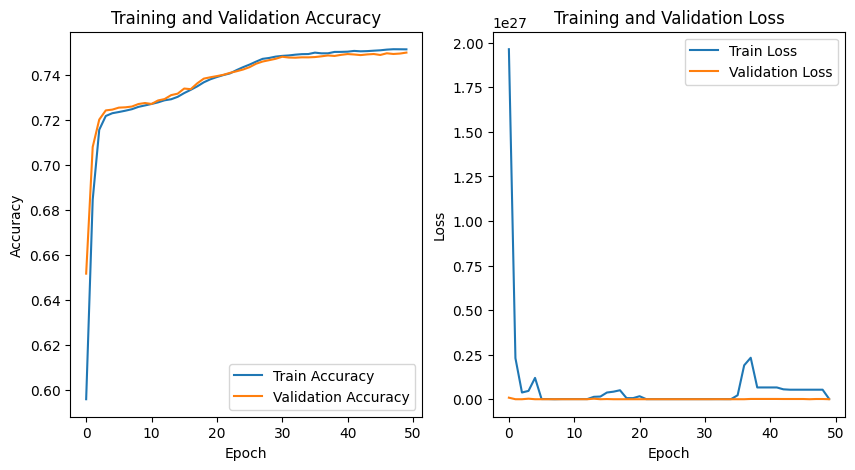

Epoch [50/50], Train Loss: 1845480207505436329377792.0000, Train Accuracy: 0.7515, Validation Loss: 40913008387679957549056.0000, Validation Accuracy: 0.7501


In [15]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = torch.sigmoid(outputs).round()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(running_loss / len(val_loader))
    val_accuracies.append(correct / total)

    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

In [16]:
# Save the model state
model_save_path = '/content/drive/My Drive/cog403_model2.pth'
torch.save(model.state_dict(), model_save_path)

Evaluate on test set

In [17]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 4206009015475142788120576.0000, Test Accuracy: 0.7499


Load model

In [21]:
loaded_model = BinaryClassifier()

# Load the state dictionary
model_save_path = '/content/drive/My Drive/cog403_model2.pth'
loaded_model.load_state_dict(torch.load(model_save_path))

# # Ensure that the model is in evaluation mode if you are making predictions and not training
loaded_model.eval()

BinaryClassifier(
  (layers): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)

Generate Shapley plots

In [20]:
import shap

# Prepare data
background = X_train[:100]        # can adjust the number of images
test_samples = X_train[100:105]   # can adjust the number of images

In [36]:
# Now, use these tensors with SHAP's DeepExplainer
explainer = shap.DeepExplainer(loaded_model, background)

# Calculate SHAP values
shap_values = explainer.shap_values(test_samples)
shap_values_squeezed = shap_values.squeeze(-1)
test_samples_np = test_samples.numpy()

print(f"shap_values_squeezed.shape: {shap_values_squeezed.shape}")
print(f"test_samples_np.shape: {test_samples_np.shape}")

# Visualize the SHAP values for the first instance in your dataset
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_squeezed, test_samples_np)

shap_values_squeezed.shape: (5, 25)
test_samples_np.shape: (5, 25)
